In [ ]:



class dA:
    def __init__(self,n_visible = 5, n_hidden = 3, lr=0.001, corruption_level=0.0, gracePeriod = 10000, hiddenRatio=None):
        
        self.n_visible = n_visible# num of units in visible (input) layer
        self.n_hidden = n_hidden# num of units in hidden layer
        self.lr = lr
        self.corruption_level = corruption_level
        self.gracePeriod = gracePeriod
        self.hiddenRatio = hiddenRatio

        if self.hiddenRatio is not None:
            self.n_hidden = int(numpy.ceil(self.n_visible*self.hiddenRatio))

        # for 0-1 normlaization
        self.norm_max = numpy.ones((self.n_visible,)) * -numpy.Inf
        self.norm_min = numpy.ones((self.n_visible,)) * numpy.Inf
        self.n = 0

        self.rng = numpy.random.RandomState(1234)

        a = 1. / self.n_visible
        self.W = numpy.array(self.rng.uniform(  # initialize W uniformly
            low=-a,
            high=a,
            size=(self.n_visible, self.n_hidden)))

        self.hbias = numpy.zeros(self.n_hidden)  # initialize h bias 0
        self.vbias = numpy.zeros(self.n_visible)  # initialize v bias 0
        self.W_prime = self.W.T


    def get_corrupted_input(self, input, corruption_level):
        assert corruption_level < 1

        return self.rng.binomial(size=input.shape,
                                 n=1,
                                 p=1 - corruption_level) * input

    # Encode
    def get_hidden_values(self, input):
        return sigmoid(numpy.dot(input, self.W) + self.hbias)

    # Decode
    def get_reconstructed_input(self, hidden):
        return sigmoid(numpy.dot(hidden, self.W_prime) + self.vbias)

    def train(self, x):
        self.n = self.n + 1
        # update norms
        self.norm_max[x > self.norm_max] = x[x > self.norm_max]
        self.norm_min[x < self.norm_min] = x[x < self.norm_min]

        # 0-1 normalize
        x = (x - self.norm_min) / (self.norm_max - self.norm_min + 0.0000000000000001)

        if self.corruption_level > 0.0:
            tilde_x = self.get_corrupted_input(x, self.corruption_level)
        else:
            tilde_x = x
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)

        L_h2 = x - z
        L_h1 = numpy.dot(L_h2, self.W) * y * (1 - y)

        L_vbias = L_h2
        L_hbias = L_h1
        L_W = numpy.outer(tilde_x.T, L_h1) + numpy.outer(L_h2.T, y)

        self.W += self.lr * L_W
        self.hbias += self.lr * numpy.mean(L_hbias, axis=0)
        self.vbias += self.lr * numpy.mean(L_vbias, axis=0)
        return numpy.sqrt(numpy.mean(L_h2**2)) #the RMSE reconstruction error during training


    def reconstruct(self, x):
        y = self.get_hidden_values(x)
        z = self.get_reconstructed_input(y)
        return z

    def execute(self, x): #returns MSE of the reconstruction of x
        if self.n < self.gracePeriod:
            return 0.0
        else:
            # 0-1 normalize
            x = (x - self.norm_min) / (self.norm_max - self.norm_min + 0.0000000000000001)
            z = self.reconstruct(x)
            rmse = numpy.sqrt(((x - z) ** 2).mean()) #MSE
            return rmse


    def inGrace(self):
        return self.n < self.gracePeriod







from scipy.cluster.hierarchy import linkage ,fcluster,fclusterdata,dendrogram,to_tree
class fm:
    def __init__(self,n):
        self.n = n
        self.c = np.zeros(n) #特征数量
        self.c_r = np.zeros(n) #特征线性加和
        self.c_rs = np.zeros(n) #特征线性残差和
        self.C = np.zeros((n,n)) #部分相关矩阵
        self.N = 0 #更新的次数
    
    def fm_ready(self,x):
        self.N += 1
        self.c += x
        c_rt = x - self.c/self.N
        self.c_r += c_rt
        self.c_rs += c_rt**2
        self.C += np.outer(c_rt,c_rt)
    
    def fm_run(self,maxn):
    #根据公式计算距离
        c_rs_sqrt = np.sqrt(self.c_rs)
        C_rs_sqrt = np.outer(c_rs_sqrt,c_rs_sqrt)
        C_rs_sqrt[C_rs_sqrt==0] = 1e-100 
        D = 1-self.C/C_rs_sqrt
        D[D<0] = 0
        result = linkage(D[np.triu_indices(self.n, 1)],method='average',metric='euclidean')#层次聚类
        mapv = self.__breakClust__(to_tree(result),maxn)
        fcluster(result,t=0.99,criterion='inconsistent',depth=2,R=None,monocrit=None)#这个需要先计算linkage，再出结果
        plt.figure(figsize=(10,5))
        dendrogram(result,get_leaves=False,show_leaf_counts=False)#这个可以绘制出树形图
        return mapv
        
    def __breakClust__(self,dendro,maxn):
        if dendro.count <= maxn: #当找到一个不大于m的簇时
            return [dendro.pre_order()] #返回该簇中原始特征id
        return self.__breakClust__(dendro.get_left(),maxn) + self.__breakClust__(dendro.get_right(),maxn)#否则继续搜索子簇
        
        
class kitnet:
# 参数初始化
    def __init__(self,n=0,max_autoencoder_size=10,FM_period=10,AD_period=10,learning_rate=0.1,hidden_ratio=0.75,feature_map=None):
        self.n = n#实例特征数，115
        self.m=max_autoencoder_size#自编码器最大输入数量，即簇中最大特征数
        self.FM_period=FMnum#FM模块训练集实例数
        self.AD_period=ADnum#AD模块训练集实例数
        self.lr = learning_rate#学习率
        self.hr = hidden_ratio #自编码器隐层神经元和输出层的比例，压缩率
        self.trained = 0 # 已训练实例数
        self.executed = 0 #已执行测试的实例数
        self.v = feature_map #映射结果
        self.FM =fm(self.n) #初始化FM模块参数
        self.ensembleLayer = []#集成层
        self.outputLayer = None#输出层
        
    def process1(self,x):
        self.FM.fm_ready(x)
        if self.trained == self.FM_period: #当接收到的实例数=FM模块训练集实例数时，可以进行FM模块的训练
            self.v = self.FM.fm_run(self.m)#层次聚类，找到映射
            self.createAD()#创建自编码器
            print(self.ensembleLayer)
            print("The Feature-Mapper found a mapping: "+str(self.n)+" features to "+str(len(self.v))+" autoencoders.")
        self.trained += 1
        
    def process2(self,x): 
        l1 = np.zeros(len(self.ensembleLayer))## 集成层模型训练
        for a in range(len(self.ensembleLayer)):
            xi = x[self.v[a]]
            l1[a] = self.ensembleLayer[a].train(xi)
            self.outputLayer.train(l1)## 输出层模型训练
        self.trained += 1

    def process3(self,x):
        self.executed += 1 
        l1 = np.zeros(len(self.ensembleLayer))
        for a in range(len(self.ensembleLayer)):  
            xi = x[self.v[a]]# FM模块的v作为集成层输入
            l1[a] = self.ensembleLayer[a].execute(xi)## 集成层输出作为输出层输入
        return self.outputLayer.execute(l1)

    def createAD(self):
        # 集成层构建，使用dA class
        for x in self.v:
            ad = dA(n_visible=len(x), n_hidden=0, lr=self.lr, corruption_level=0, gracePeriod=0, hiddenRatio=self.hr)
            self.ensembleLayer.append(ad)

        # 输出层构建
        ad = dA(len(self.v), n_hidden=0, lr=self.lr, corruption_level=0, gracePeriod=0, hiddenRatio=self.hr)
        self.outputLayer = ad
        
import numpy as np 
import pandas as pd
import time
import sys

print("Reading dataset...")
X = pd.read_csv("F:\KitNET-py-master\dataset\mirai3.csv",header=None).values#读取数据集，这里X代表一个数据流
print(X)
# KitNET params:
maxn = 1 #集合层中每个自编码器输入层最大神经元数量
FMnum = 5000 #特征映射模型训练所需要的实例数量
ADnum = 50000 #自编码器模型训练所需要的实例数量

K = kitnet(X.shape[1],maxn,FMnum,ADnum)
RMSEs = np.zeros(X.shape[0]) # a place to save the scores


print("Running KitNET...")
start = time.time()
# X代表一个数据流，由于模型是在线处理数据，每个实例在执行process()方法后会被丢弃
for i in range(X.shape[0]):
    if i % 1000 == 0:
        print(i)
    #fm模型训练阶段  
    if i<=FMnum:
        RMSEs[i] = K.process1(X[i,]) 
    #fm测试，ad模型训练阶段
    elif i<=(FMnum+ADnum):
        RMSEs[i]= K.process2(X[i,])
    #异常检测模型测试阶段
    else:
        RMSEs[i]= K.process3(X[i,])
        
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))
print(RMSEs)
#print(K.v)





In [72]:

import numpy
from scipy.stats import norm
numpy.seterr(all='ignore')

def pdf(x,mu,sigma): #normal distribution pdf
    x = (x-mu)/sigma
    return numpy.exp(-x**2/2)/(numpy.sqrt(2*numpy.pi)*sigma)

def invLogCDF(x,mu,sigma): #normal distribution cdf
    x = (x - mu) / sigma
    return norm.logcdf(-x) #note: we mutiple by -1 after normalization to better get the 1-cdf

def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))


def dsigmoid(x):
    return x * (1. - x)

def tanh(x):
    return numpy.tanh(x)

def dtanh(x):
    return 1. - x * x

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


def ReLU(x):
    return x * (x > 0)

def dReLU(x):
    return 1. * (x > 0)

class rollmean:
    def __init__(self,k):
        self.winsize = k
        self.window = numpy.zeros(self.winsize)
        self.pointer = 0

    def apply(self,newval):
        self.window[self.pointer]=newval
        self.pointer = (self.pointer+1) % self.winsize
        return numpy.mean(self.window)

# probability density for the Gaussian dist
# def gaussian(x, mean=0.0, scale=1.0):
#     s = 2 * numpy.power(scale, 2)
#     e = numpy.exp( - numpy.power((x - mean), 2) / s )

#     return e / numpy.square(numpy.pi * s)



Plotting results


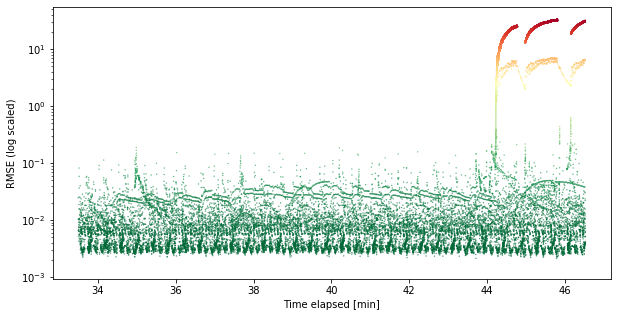

In [153]:
from sklearn.metrics  import roc_curve,auc
from scipy.stats import norm
benignSample = np.log(RMSEs[FMnum+ADnum+1:71000])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

# RMSE分数散点图
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
plt.figure(figsize=(10,5))
timestamps = pd.read_csv("F:\KitNET-py-master\dataset\mirai3_ts.csv",header=None).values#横坐标：时间min
fig = plt.scatter(timestamps[FMnum+ADnum+1:],RMSEs[FMnum+ADnum+1:],s=0.1,c=logProbs[FMnum+ADnum+1:],cmap='RdYlGn')
plt.yscale("log")
#plt.title("K")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
plt.show()



0.1573563037305839
[[15995     5]
 [ 5601 23398]]
0.4728931120851597 0.9062815738922874


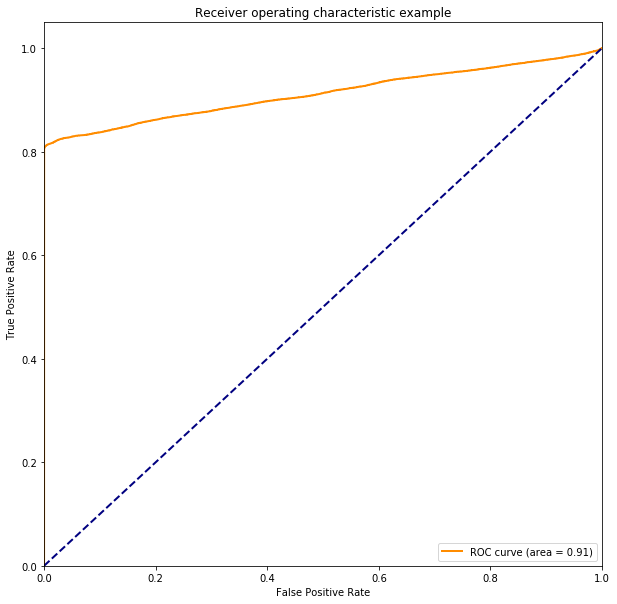

In [139]:
import sklearn.metrics as sk
print(RMSEs[72662])
thelod=0.15735
y_test= np.zeros(X.shape[0])
for i in range(X.shape[0]):
    if RMSEs[i]>thelod:
        y_test[i]=1
    else:
        y_test[i]=0
#print(y_test)

y= np.zeros(X.shape[0])
for i in range(X.shape[0]):
    if i<=71000:
        y[i]=0
    else:
        y[i]=1
#print(y)

r=sk.confusion_matrix(y[FMnum+ADnum+1:], y_test[FMnum+ADnum+1:], labels=None, sample_weight=None)
print(r)
fpr,tpr,threshold=roc_curve(y[FMnum+ADnum+1:],RMSEs[FMnum+ADnum+1:])
print (np.mean(fpr),np.mean(tpr))
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
    


0.1573563037305839
[[15994     6]
 [ 5594 23405]]
0.4728931120851597 0.9062815738922874


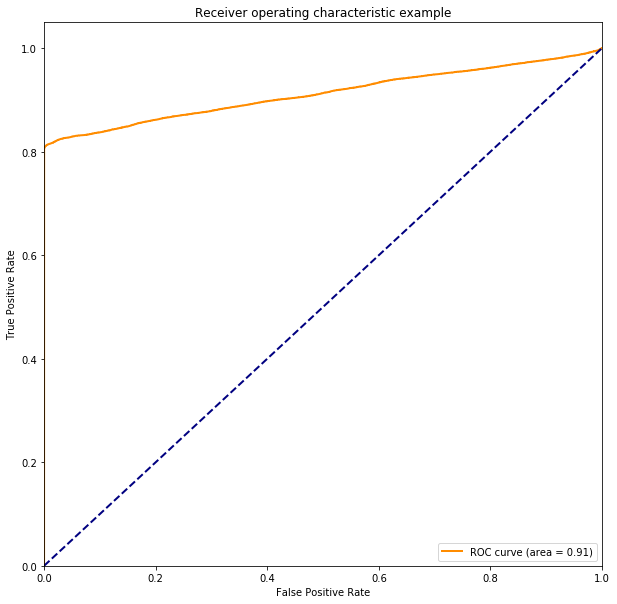

In [143]:
import sklearn.metrics as sk
print(RMSEs[72662])
thelod=0.15
y_test= np.zeros(X.shape[0])
for i in range(X.shape[0]):
    if RMSEs[i]>thelod:
        y_test[i]=1
    else:
        y_test[i]=0
#print(y_test)

y= np.zeros(X.shape[0])
for i in range(X.shape[0]):
    if i<=71000:
        y[i]=0
    else:
        y[i]=1
#y=np.append(y1,y2)
#print(y)
r=sk.confusion_matrix(y[FMnum+ADnum+1:], y_test[FMnum+ADnum+1:], labels=None, sample_weight=None)
print(r)
fpr,tpr,threshold=roc_curve(y[FMnum+ADnum+1:],RMSEs[FMnum+ADnum+1:])
print (np.mean(fpr),np.mean(tpr))
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, ' find eer')

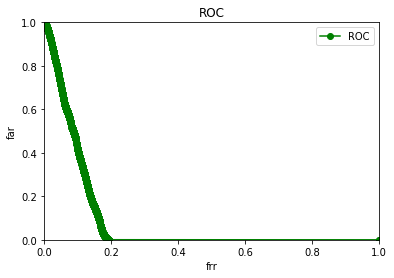

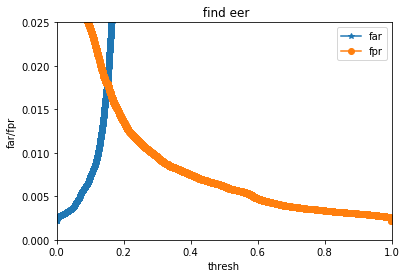

In [149]:
fpr,tpr,threshold=roc_curve(y[FMnum+ADnum+1:],RMSEs[FMnum+ADnum+1:])
plt.figure()
plt.plot(1-tpr, fpr, color = 'green', marker = 'o',label = 'ROC')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('frr')
plt.ylabel('far')
plt.title('ROC')

plt.figure()
plt.plot(1-tpr, threshold,marker = '*',label = 'far')
plt.plot(fpr, threshold, marker = 'o',label = 'fpr')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,0.025])
plt.xlabel('thresh')
plt.ylabel('far/fpr')
plt.title(' find eer')